In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import re, copy

SEASON_SPLIT = 2024

## Reading in data from csv files

In [2]:
matches = pd.read_csv('matches.csv', index_col=0)
print(matches.shape)

(2983, 40)


In [3]:
next_matches = pd.read_csv('next_matches.csv', index_col=0)
print(next_matches.shape)

(20, 22)


In [4]:
history_matches = pd.read_csv('history.csv', index_col=0)
print(history_matches.shape)

(24271, 15)


In [5]:
odds_matches_2026 = pd.read_csv('odds/2026_prem.csv', index_col=0)
odds_matches_2025 = pd.read_csv('odds/2025_prem.csv', index_col=0)
odds_matches_2024 = pd.read_csv('odds/2024_prem.csv', index_col=0)
odds_matches_2023 = pd.read_csv('odds/2023_prem.csv', index_col=0)
odds_matches = pd.concat([odds_matches_2026, odds_matches_2025, odds_matches_2024, odds_matches_2023])

In [6]:
# getting the matches of the desired league
LEAGUE = 'Premier League'
league_matches = matches[matches['Comp'] == LEAGUE]
league_history_matches = history_matches[history_matches['Comp'] == LEAGUE]
league_matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,2CrdY,Fls,Fld,Off,Crs,Int,TklW,Won%,SCA,GCA
8,2025-09-14,14:00 (23:00),Premier League,Matchweek 4,Sun,Away,W,1,0,Burnley,...,0.0,9.0,8.0,1.0,44.0,7.0,7.0,62.8,49.0,1.0
9,2025-09-14,14:00 (23:00),Premier League,Matchweek 4,Sun,Home,L,0,1,Liverpool,...,1.0,9.0,7.0,3.0,3.0,17.0,11.0,37.2,5.0,0.0
10,2025-09-14,16:30 (01:30),Premier League,Matchweek 4,Sun,Home,W,3,0,Manchester Utd,...,0.0,8.0,7.0,2.0,2.0,10.0,7.0,62.1,23.0,5.0
11,2025-09-14,16:30 (01:30),Premier League,Matchweek 4,Sun,Away,L,0,3,Manchester City,...,0.0,8.0,8.0,3.0,23.0,13.0,15.0,37.9,22.0,0.0
12,2025-09-13,15:00 (00:00),Premier League,Matchweek 4,Sat,Away,D,0,0,Everton,...,0.0,15.0,16.0,2.0,10.0,4.0,11.0,45.9,11.0,0.0


## Date Exploration and Analysis

In [7]:
league_matches['Team'].value_counts()

Team
Liverpool                   118
Manchester City             118
Manchester United           118
Aston Villa                 118
Nottingham Forest           118
Brentford                   118
Arsenal                     118
Wolverhampton Wanderers     118
West Ham United             118
Everton                     118
Brighton and Hove Albion    118
Crystal Palace              118
Chelsea                     118
Newcastle United            118
Tottenham Hotspur           118
Bournemouth                 118
Fulham                      118
Southampton                  76
Leicester City               76
Burnley                      42
Leeds United                 42
Luton Town                   38
Ipswich Town                 38
Sheffield United             38
Sunderland                    4
Name: count, dtype: int64

In [8]:
league_matches['Opponent'].value_counts()

Opponent
Liverpool          118
Arsenal            118
Manchester Utd     118
Manchester City    118
Everton            118
Chelsea            118
Nott'ham Forest    118
Newcastle Utd      118
Tottenham          118
Aston Villa        118
Fulham             118
Bournemouth        118
Brentford          118
Wolves             118
West Ham           118
Brighton           118
Crystal Palace     118
Leicester City      76
Southampton         76
Burnley             42
Leeds United        42
Luton Town          38
Ipswich Town        38
Sheffield Utd       38
Sunderland           4
Name: count, dtype: int64

In [9]:
league_matches.dtypes

Date              object
Time              object
Comp              object
Round             object
Day               object
Venue             object
Result            object
GF                object
GA                object
Opponent          object
xG               float64
xGA              float64
Poss             float64
Attendance       float64
Captain           object
Formation         object
Opp Formation     object
Referee           object
Match Report      object
Notes             object
Season             int64
Team              object
Sh               float64
SoT              float64
Dist             float64
FK               float64
PK               float64
PKatt            float64
CrdY             float64
CrdR             float64
2CrdY            float64
Fls              float64
Fld              float64
Off              float64
Crs              float64
Int              float64
TklW             float64
Won%             float64
SCA              float64
GCA              float64


In [10]:
team_names = sorted(league_matches['Team'].unique())
opp_names = sorted(league_matches['Opponent'].unique())

exculsive_team_names = []
exculsive_opp_names = []

# finding out the team names that are written differently in the opponent column
for i in team_names:
    if (i not in opp_names):
        exculsive_team_names.append(i)
        print(i)

print('---------------------------')

for i in opp_names:
    if (i not in team_names):
        exculsive_opp_names.append(i)
        print(i)

Brighton and Hove Albion
Manchester United
Newcastle United
Nottingham Forest
Sheffield United
Tottenham Hotspur
West Ham United
Wolverhampton Wanderers
---------------------------
Brighton
Manchester Utd
Newcastle Utd
Nott'ham Forest
Sheffield Utd
Tottenham
West Ham
Wolves


In [11]:
team_names = set(odds_matches['HomeTeam']) | set(odds_matches['AwayTeam'])
team_names = sorted(team_names)
for team_name in team_names:
    if team_name not in league_history_matches['Home'].unique() and team_name not in league_history_matches['Away'].unique():
        print(team_name)
        exculsive_team_names.append(team_name)

Ipswich
Leeds
Leicester
Luton
Man City
Man United
Newcastle
Nott'm Forest
Sheffield United


In [12]:
odds_missing_opp_names = ['Ipswich Town', 'Leeds United', 'Leicester City',
                          'Luton Town', 'Manchester City', 'Manchester Utd',
                          'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd']

In [13]:
sorted(league_history_matches['Home'].unique())

['Arsenal',
 'Aston Villa',
 'Barnsley',
 'Birmingham City',
 'Blackburn',
 'Blackpool',
 'Bolton',
 'Bournemouth',
 'Bradford City',
 'Brentford',
 'Brighton',
 'Burnley',
 'Cardiff City',
 'Charlton Ath',
 'Chelsea',
 'Coventry City',
 'Crystal Palace',
 'Derby County',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Hull City',
 'Ipswich Town',
 'Leeds United',
 'Leicester City',
 'Liverpool',
 'Luton Town',
 'Manchester City',
 'Manchester Utd',
 'Middlesbrough',
 'Newcastle Utd',
 'Norwich City',
 "Nott'ham Forest",
 'Portsmouth',
 'QPR',
 'Reading',
 'Sheffield Utd',
 'Sheffield Weds',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wigan Athletic',
 'Wolves']

In [14]:
exculsive_opp_names.extend(odds_missing_opp_names)

In [15]:
# creating class to map team names written differently in opponent column to 
# corresponding team names.
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {}

for team_name, opp_name in zip(exculsive_team_names, exculsive_opp_names):
    map_values[team_name] = opp_name

mapping = MissingDict(**map_values)

In [16]:
odds_matches['Date'] = pd.to_datetime(odds_matches['Date'], dayfirst=True)
odds_matches['HomeTeam'] = odds_matches['HomeTeam'].map(mapping)
odds_matches['AwayTeam'] = odds_matches['AwayTeam'].map(mapping)
odds_matches = odds_matches[['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 
                             'B365A', 'PSH', 'PSD',
                             'PSA', 'AvgH', 'AvgD', 'AvgA']]

In [17]:
# applying mapping to ensure consistent team names
matches['Team'] = matches['Team'].map(mapping)
# creating a dictionary of team codes to ensure consistent team codes for each
# team
team_mapping_dict = {key: value for key, value in zip(matches['Team'], matches['Team'].astype('category').cat.codes)}
matches['Team_code'] = matches['Team'].map(team_mapping_dict)
matches['Opp_code'] = matches['Opponent'].map(team_mapping_dict)

# simplifying date and venue into respective codes
matches['Date'] = pd.to_datetime(matches['Date'])
matches['Venue_code'] = matches['Venue'].astype('category').cat.codes
matches['Hour'] = matches['Time'].str.replace(":.+", "", regex=True).astype('int')
matches['Day_code'] = matches['Date'].dt.dayofweek

matches['Target'] = matches['Result'].astype('category').cat.codes

matches['GF'] = matches['GF'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
matches['GA'] = matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', str(x)).group(0)))

In [18]:
matches_copy1 = matches.merge(odds_matches, how='left', left_on=['Date', 'Team', 'Opponent'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
matches_copy2 = matches.merge(odds_matches, how='left', left_on=['Date', 'Opponent', 'Team'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
matches = matches_copy1.combine_first(matches_copy2)

In [19]:
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,AwayTeam,B365H,B365D,B365A,PSH,PSD,PSA,AvgH,AvgD,AvgA
0,2025-09-17,20:00 (05:00),Champions Lg,League phase,Wed,Home,W,3,2,es Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-09-17,21:00 (05:00),Champions Lg,League phase,Wed,Away,L,1,3,de Bayern Munich,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-09-17,20:00 (05:00),EFL Cup,Third round,Wed,Away,L,2,3,Swansea City,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-09-16,20:00 (05:00),EFL Cup,Third round,Tue,Home,D,1,1,Aston Villa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-09-16,20:00 (05:00),EFL Cup,Third round,Tue,Away,D,1,1,Brentford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
matches = matches.drop(columns=['Time', 'Day', 'Result', 'Attendance',
                                'Match Report', 'Notes','Captain', 'Formation',
                                'Opp Formation', 'Referee', 'HomeTeam', 'AwayTeam'])

In [21]:
matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
Venue                 object
GF                     int64
GA                     int64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Sh                   float64
SoT                  float64
Dist                 float64
FK                   float64
PK                   float64
PKatt                float64
CrdY                 float64
CrdR                 float64
2CrdY                float64
Fls                  float64
Fld                  float64
Off                  float64
Crs                  float64
Int                  float64
TklW                 float64
Won%                 float64
SCA                  float64
GCA                  float64
Team_code              int64
Opp_code             float64
Venue_code              int8
Hour                   int64
Day_code      

In [22]:
matches['Target'].value_counts()

Target
2    1263
1    1066
0     654
Name: count, dtype: int64

In [23]:
next_matches['Team'] = next_matches['Team'].map(mapping)
next_matches['Team_code'] = next_matches['Team'].map(team_mapping_dict)
next_matches['Opp_code'] = next_matches['Opponent'].map(team_mapping_dict)

next_matches['Date'] = pd.to_datetime(next_matches['Date'])
next_matches['Venue_code'] = next_matches['Venue'].astype('category').cat.codes
next_matches['Hour'] = next_matches['Time'].str.replace(":.+", "", regex=True).astype('int')
next_matches['Day_code'] = next_matches['Date'].dt.dayofweek

In [24]:
next_matches_copy1 = next_matches.merge(odds_matches, how='left', left_on=['Date', 'Team', 'Opponent'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
next_matches_copy2 = next_matches.merge(odds_matches, how='left', left_on=['Date', 'Opponent', 'Team'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])
next_matches = next_matches_copy1.combine_first(next_matches_copy2)

In [25]:
next_matches = next_matches.drop(columns=['Time', 'Day', 'Venue', 'Result', 
                                          'Attendance', 'Match Report', 'Notes',
                                          'Captain', 'Formation',
                                          'Opp Formation', 'Referee', 'HomeTeam', 'AwayTeam'])

In [26]:
next_matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
GF                   float64
GA                   float64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Team_code              int64
Opp_code               int64
Venue_code              int8
Hour                   int64
Day_code               int32
B365H                float64
B365D                float64
B365A                float64
PSH                  float64
PSD                  float64
PSA                  float64
AvgH                 float64
AvgD                 float64
AvgA                 float64
dtype: object

In [27]:
def get_Target(row):
    if row['GF'] > row['GA']:
        return 2
    elif row['GF'] < row['GA']:
        return 1
    else:
        return 0

In [28]:
history_matches['Team'] = history_matches['Team'].map(mapping)
history_matches['Home'] = history_matches['Home'].map(mapping)
history_matches['Away'] = history_matches['Away'].map(mapping)
history_matches['Date'] = pd.to_datetime(history_matches['Date'])
history_matches['GF'] = history_matches['Score'].apply(lambda score: (score.split('–')[0]))
history_matches['GA'] = history_matches['Score'].apply(lambda score: score.split('–')[1])
history_matches['GF'] = history_matches['GF'].apply(lambda x: int(re.search(r'[0-9]+$', x).group(0)))
history_matches['GA'] = history_matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
history_matches['Target'] = history_matches.apply(get_Target, axis=1)

for index, row in history_matches.iterrows():
    if row['Team'] == row['Away']:
        temp = row['Home']
        history_matches.loc[index, 'Home'] = row['Away']
        history_matches.loc[index, 'Away'] = temp
        temp = row['GF']
        history_matches.loc[index, 'GF'] = row['GA']
        history_matches.loc[index, 'GA'] = temp

In [29]:
history_matches['Opponent'] = history_matches['Away']

In [30]:
history_matches = history_matches.merge(odds_matches, how='left', left_on=['Date', 'Team', 'Away'],
                        right_on=['Date', 'HomeTeam', 'AwayTeam'])

In [31]:
history_matches = history_matches.drop(columns=['Time', 'Day', 'Venue', 
                                                'Attendance', 
                                                'Notes', 'Referee',
                                                'Home', 'Away', 'HomeTeam', 'AwayTeam'])

In [32]:
history_matches.dtypes

Comp                object
Round               object
Date        datetime64[ns]
xG                 float64
Score               object
xG.1               float64
Team                object
GF                   int64
GA                   int64
Target               int64
Opponent            object
B365H              float64
B365D              float64
B365A              float64
PSH                float64
PSD                float64
PSA                float64
AvgH               float64
AvgD               float64
AvgA               float64
dtype: object

In [33]:
# function to compute rolling averages of given columns for each match
def rolling_avgs(group, cols, new_cols, num_past_matches_considered=3):
    group = group.sort_values('Date')
    rolling_stats = group[cols].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).mean()
    group[new_cols] = rolling_stats.fillna(0)
    return group

In [34]:
# rolling avgs for matches across the desired league
league_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA']
league_ravg_new_cols = [f"{c}league_rolling" for c in league_ravg_cols]

In [35]:
# stats for last match
last_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA', 'Target']
last_ravg_new_cols = [f"{c}last_rolling" for c in last_ravg_cols]

In [36]:
# rolling avgs for matches across all head to head matches
hth_ravg_cols = ['xG', 'xG.1', 'GF', 'GA']
hth_ravg_new_cols = [f"{c}hth_rolling" for c in hth_ravg_cols]

In [37]:
def rolling_avg_match_rest(group, num_past_matches_considered=3):
    group = group.sort_values('Date')
    group['days_diff'] = group['Date'].diff().dt.days
    rolling_stats = group['days_diff'].rolling(num_past_matches_considered, 
                                        min_periods=1).mean()
    group[f'rolling_rests_{num_past_matches_considered}'] = rolling_stats.fillna(0)
    return group

In [38]:
def rolling_match_results(group, name, num_past_matches_considered=3):
    group = group.sort_values('Date')
    group['is_win'] = (group['Target'] == 2).astype(int)
    rolling_stats = group['is_win'].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).sum()
    group[f'{name}num_wins_rolling'] = rolling_stats.fillna(0)
    return group

In [39]:
all_matches = pd.concat([matches, next_matches])
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
league_matches = all_matches[all_matches['Comp'] == LEAGUE]
team_league_matches = league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, league_ravg_cols, league_ravg_new_cols),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
team_league_matches = team_league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'league'),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
# team_matches = team_matches.droplevel('Team')
# team_matches.index = range(team_matches.shape[0])
team_last_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, last_ravg_cols, last_ravg_new_cols,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
hth_and_next_matches = pd.concat([history_matches, next_matches])
team_hth_matches = hth_and_next_matches.groupby(['Team', 'Opponent'], group_keys=True).apply(lambda x: rolling_avgs(x, hth_ravg_cols, hth_ravg_new_cols),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)

team_hth_matches = team_hth_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'hth'),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)


In [40]:
opp_team_league_matches = team_league_matches.copy()
opp_team_league_matches = opp_team_league_matches.add_prefix('Opp_')

opp_team_last_matches = team_last_matches.copy()
opp_team_last_matches = opp_team_last_matches.add_prefix('Opp_')

In [41]:
team_league_matches = team_league_matches.merge(opp_team_league_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_league_matches = team_league_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_Target', 'Opp_days_diff', 'Opp_is_win'])
team_last_matches = team_last_matches.merge(opp_team_last_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_last_matches = team_last_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_days_diff'])

In [42]:
last_ravg_new_cols_merge = copy.deepcopy(last_ravg_new_cols)
hth_ravg_new_cols_merge = copy.deepcopy(hth_ravg_new_cols)
last_ravg_new_cols_merge = last_ravg_new_cols_merge + ['Opp_' + column for column in last_ravg_new_cols_merge]
last_ravg_new_cols_merge.append('Date')
hth_ravg_new_cols_merge.append('Date')
last_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('hthnum_wins_rolling')
team_matches = team_league_matches.merge(team_last_matches[last_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')
team_matches = team_matches.merge(team_hth_matches[hth_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')

In [43]:
team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Opp_SCAlast_rolling,Opp_GCAlast_rolling,Opp_xGlast_rolling,Opp_xGAlast_rolling,Opp_Targetlast_rolling,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling
0,Arsenal,2022-08-05,Premier League,Matchweek 1,Away,2.0,0.0,Crystal Palace,1.0,1.2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Arsenal,2022-08-13,Premier League,Matchweek 2,Home,4.0,2.0,Leicester City,2.7,0.5,...,25.0,4.0,0.6,0.8,0.0,1.000000,0.700000,1.333333,0.333333,3.0
2,Arsenal,2022-08-20,Premier League,Matchweek 3,Away,3.0,0.0,Bournemouth,1.3,0.3,...,4.0,0.0,0.1,1.7,1.0,0.866667,1.100000,1.333333,1.000000,3.0
3,Arsenal,2022-08-27,Premier League,Matchweek 4,Home,2.0,1.0,Fulham,2.6,0.8,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,Arsenal,2022-08-31,Premier League,Matchweek 5,Home,2.0,1.0,Aston Villa,2.4,0.4,...,17.0,0.0,0.5,0.6,1.0,1.450000,1.400000,2.666667,0.666667,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Wolves,2025-08-16,Premier League,Matchweek 1,Home,0.0,4.0,Manchester City,0.6,2.4,...,35.0,3.0,3.0,1.3,2.0,NaN,NaN,NaN,NaN,NaN
2376,Wolves,2025-08-23,Premier League,Matchweek 2,Away,0.0,1.0,Bournemouth,0.5,1.3,...,18.0,3.0,1.7,2.2,1.0,NaN,NaN,NaN,NaN,NaN
2377,Wolves,2025-08-30,Premier League,Matchweek 3,Home,2.0,3.0,Everton,1.1,1.9,...,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
2378,Wolves,2025-09-13,Premier League,Matchweek 4,Away,0.0,1.0,Newcastle Utd,0.5,1.5,...,15.0,0.0,0.5,0.7,0.0,NaN,NaN,NaN,NaN,NaN


In [44]:
team_matches = team_matches[team_matches['Comp'] == LEAGUE]

In [45]:
team_matches.shape

(2380, 177)

In [49]:
sorted_round = sorted(team_matches['Round'].unique(), key=lambda round:int((re.search('[0-9]+$', round)).group(0)))
round_mapping_dict = {value: key for key, value in enumerate(sorted_round, start=1)}
team_matches['Round'] = team_matches['Round'].map(round_mapping_dict)

In [56]:
# add ranking of the teams at each match
team_matches = team_matches.sort_values('Date').reset_index(drop=True)

curr_season = 0
for season_gameweek, stats in team_matches.groupby(['Season', 'Round'], sort=True):
    if curr_season != season_gameweek[0]:
        curr_season = season_gameweek[0]
        # starting with -1 points since every team will get 1 point from
        # first iteration
        standings = defaultdict(lambda : {'points': -1, 'goal_diff': 0, 'GF': 0})

    sorted_standings = sorted(standings.items(), 
                              key=lambda x: (-x[1]['points'], -x[1]['goal_diff'], -x[1]['GF'], x[0]))
    ranking = {team: pos for pos, (team, stats) in enumerate(sorted_standings, start=1)}
    
    # setting current league position
    for index, row in stats.iterrows():
        team_matches.at[index, 'Team_position'] = ranking.get(row['Team'], 0)
        team_matches.at[index, 'Opp_position'] = ranking.get(row['Opponent'], 0)

    # updating ranking data
    for index, row in stats.iterrows():
        if pd.isna(stats.loc[index, 'GF']):
            goals_for = 0
        else:
            goals_for = row['GF']
        if pd.isna(stats.loc[index, 'GA']):
            goals_against = 0
        else:
            goals_against = row['GA']
        standings[row['Team']]['GF'] += goals_for
        standings[row['Team']]['goal_diff'] += goals_for - goals_against
        
        if goals_for > goals_against:
            standings[row['Team']]['points'] += 3
        elif goals_for < goals_against:
            standings[row['Team']]['points'] += 0
        else:
            standings[row['Team']]['points'] += 1

team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Opp_xGlast_rolling,Opp_xGAlast_rolling,Opp_Targetlast_rolling,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling,Team_position,Opp_position
0,Arsenal,2022-08-05,Premier League,1,Away,2.0,0.0,Crystal Palace,1.0,1.2,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,Crystal Palace,2022-08-05,Premier League,1,Home,0.0,2.0,Arsenal,1.2,1.0,...,0.0,0.0,0.0,1.266667,0.966667,2.000000,1.000000,2.0,0.0,0.0
2,Liverpool,2022-08-06,Premier League,1,Away,2.0,2.0,Fulham,1.2,1.2,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,Leeds United,2022-08-06,Premier League,1,Home,2.0,1.0,Wolves,0.8,1.3,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,Chelsea,2022-08-06,Premier League,1,Away,1.0,0.0,Everton,1.5,0.7,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Newcastle Utd,2025-09-21,Premier League,5,NaN,NaN,NaN,Bournemouth,NaN,NaN,...,1.4,0.6,2.0,1.600000,1.250000,0.666667,2.000000,1.0,10.0,4.0
2376,Sunderland,2025-09-21,Premier League,5,NaN,NaN,NaN,Aston Villa,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,1.333333,1.000000,1.0,7.0,19.0
2377,Aston Villa,2025-09-21,Premier League,5,NaN,NaN,NaN,Sunderland,NaN,NaN,...,0.4,1.8,0.0,0.000000,0.000000,3.000000,0.666667,1.0,19.0,7.0
2378,Bournemouth,2025-09-21,Premier League,5,NaN,NaN,NaN,Newcastle Utd,NaN,NaN,...,1.5,0.5,2.0,1.966667,1.700000,1.333333,1.333333,2.0,4.0,10.0


In [61]:
team_matches = team_matches[team_matches['hthnum_wins_rolling'].notna()]
team_matches['Match_key'] = team_matches.apply(lambda row: tuple(sorted([row['Team'], row['Opponent']])), axis=1)

team_matches = team_matches.drop_duplicates(subset=['Match_key', 'Date'])
team_matches = team_matches.drop(columns=['Match_key'])

In [62]:
team_matches.shape

(1190, 179)

In [63]:
INITIAL_ATTACK_STRENGTH = 0
INITIAL_DEFENSE_STRENGTH = 0
HOME_ADVANTAGE_ADDITION = 0.2
LEARNING_RATE = 0.05

team_attack_strengths = defaultdict(lambda: INITIAL_ATTACK_STRENGTH)
team_defense_strengths = defaultdict(lambda: INITIAL_DEFENSE_STRENGTH)

def get_expected_goal(team, opp):
    expected_goal_team = np.exp(team_attack_strengths[team] - team_defense_strengths[opp] + HOME_ADVANTAGE_ADDITION)
    expected_goal_opp = np.exp(team_attack_strengths[opp] - team_defense_strengths[team])
    return (expected_goal_team, expected_goal_opp)

def update_strengths(team, opp, team_goals, opp_goals, team_xg, opp_xg):
    team_attack_strengths[team] += LEARNING_RATE * (team_goals - team_xg)
    team_defense_strengths[team] += LEARNING_RATE * (opp_xg - opp_goals)

    team_attack_strengths[opp] += LEARNING_RATE * (opp_goals - opp_xg)
    team_defense_strengths[opp] += LEARNING_RATE * (team_xg - team_goals)
    
relative_attack_strength, relative_defense_strength = [], []
expected_goal_team, expected_goal_opp = [], []

for index, row in team_matches.iterrows():
    ex_goal_team, ex_goal_opp = get_expected_goal(row['Team'], row['Opponent'])
    expected_goal_team.append(ex_goal_team)
    expected_goal_opp.append(ex_goal_opp)

    relative_attack_strength.append(team_attack_strengths[row['Team']] - team_attack_strengths[row['Opponent']])
    relative_defense_strength.append(team_defense_strengths[row['Team']] - team_defense_strengths[row['Opponent']])

    update_strengths(row['Team'], row['Opponent'], row['GF'],
                   row['GA'], row['xG'], row['xGA'])
    
team_matches['Expected_goal_team'] = expected_goal_team
team_matches['Expected_goal_opp'] = expected_goal_opp
team_matches['Relative_attack_strength'] = relative_attack_strength
team_matches['Relative_defense_strength'] = relative_defense_strength

In [64]:
total_goals_mean = (team_matches['GF'].sum() + team_matches['GA'].sum()) / team_matches.shape[0]
expected_goals_mean = (team_matches['Expected_goal_team'].sum() + team_matches['Expected_goal_team'].sum()) / team_matches.shape[0]
expected_goal_scale = total_goals_mean / expected_goals_mean

team_matches['Expected_goal_team'] *= expected_goal_scale
team_matches['Expected_goal_opp'] *= expected_goal_scale

In [65]:
import numpy as np
from scipy.stats import poisson

def match_outcome_probs(lam_team, lam_opp, max_goals=10):
    # Scoreline probability matrix
    probs = np.zeros((max_goals, max_goals))
    for i in range(max_goals):
        for j in range(max_goals):
            probs[i, j] = poisson.pmf(i, lam_team) * poisson.pmf(j, lam_opp)
    
    # Probabilities of outcomes
    p_team_win = np.sum(np.tril(probs, -1))  # lower triangle, i > j
    p_draw     = np.sum(np.diag(probs))      # diagonal, i = j
    p_opp_win = np.sum(np.triu(probs, 1))   # upper triangle, i < j
    
    return p_team_win, p_draw, p_opp_win

team_matches[['Predicted_team_win', 'Predicted_team_draw', 
              'Predicted_team_loss']] = team_matches.apply(lambda row: match_outcome_probs(row["Expected_goal_team"], row["Expected_goal_opp"]), axis=1, result_type='expand')

In [66]:
K = 20
HOME_ADVANTAGE = 40
SCALING = 400

team_ratings = defaultdict(lambda: 1500)

def get_expected_score(team_rating, opp_rating, venue):
    if venue == 'Home':
        h = HOME_ADVANTAGE 
    else:
        h = 0
    return 1 / (1 + 10 ** (-(team_rating - opp_rating + h) / SCALING))

def goal_diff_multiplier(team_goal, opp_goal):
    goal_diff = abs(team_goal - opp_goal)
    return np.log((goal_diff + 1) * (2.2 / (goal_diff + 2.2)))

def update_ratings(team, opp, team_goal, opp_goal, venue):
    if team_goal > opp_goal:
        team_result = 1
    elif team_goal == opp_goal:
        team_result = 0.5
    else:
        team_result = 0

    opp_result = 1 - team_result

    team_rating, opp_rating = team_ratings[team], team_ratings[opp]

    team_expected_result = get_expected_score(team_rating, opp_rating, venue)
    opp_expected_result = 1 - team_expected_result

    multiplier = goal_diff_multiplier(team_goal, opp_goal)

    team_ratings[team] += K * multiplier * (team_result - team_expected_result)
    team_ratings[opp] += K * multiplier * (opp_result - opp_expected_result)

ratings = []
for index, row in team_matches.iterrows():
    ratings.append(team_ratings[row['Team']] - team_ratings[row['Opponent']])
    update_ratings(row['Team'], row['Opponent'], row['GF'],
                             row['GA'], row['Venue'])
    
team_matches['Relative_ratings'] = ratings

In [67]:
team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Team_position,Opp_position,Expected_goal_team,Expected_goal_opp,Relative_attack_strength,Relative_defense_strength,Predicted_team_win,Predicted_team_draw,Predicted_team_loss,Relative_ratings
1,Crystal Palace,2022-08-05,Premier League,1,Home,0.0,2.0,Arsenal,1.2,1.0,...,0.0,0.0,0.991291,0.811601,0.000,0.000,0.385694,0.326605,0.287701,0.000000
6,Aston Villa,2022-08-06,Premier League,1,Away,0.0,2.0,Bournemouth,0.7,0.6,...,0.0,0.0,0.991291,0.811601,0.000,0.000,0.385694,0.326605,0.287701,0.000000
7,Everton,2022-08-06,Premier League,1,Home,0.0,1.0,Chelsea,0.7,1.5,...,0.0,0.0,0.991291,0.811601,0.000,0.000,0.385694,0.326605,0.287701,0.000000
8,Newcastle Utd,2022-08-06,Premier League,1,Home,2.0,0.0,Nott'ham Forest,1.7,0.3,...,0.0,0.0,0.991291,0.811601,0.000,0.000,0.385694,0.326605,0.287701,0.000000
9,Tottenham,2022-08-06,Premier League,1,Home,4.0,1.0,Southampton,1.5,0.5,...,0.0,0.0,0.991291,0.811601,0.000,0.000,0.385694,0.326605,0.287701,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2365,Manchester Utd,2025-09-20,Premier League,5,NaN,NaN,NaN,Chelsea,NaN,NaN,...,14.0,5.0,0.255701,0.185677,-0.495,0.615,0.191684,0.674049,0.134266,-60.562913
2369,Nott'ham Forest,2025-09-20,Premier League,5,NaN,NaN,NaN,Burnley,NaN,NaN,...,15.0,17.0,2.250727,1.908377,0.475,-0.510,0.464399,0.200181,0.335268,50.821271
2374,Arsenal,2025-09-21,Premier League,5,NaN,NaN,NaN,Manchester City,NaN,NaN,...,2.0,8.0,6.431791,4.647145,0.430,-0.305,0.534301,0.104784,0.225742,6.253336
2375,Newcastle Utd,2025-09-21,Premier League,5,NaN,NaN,NaN,Bournemouth,NaN,NaN,...,10.0,4.0,3.084079,0.430096,0.825,0.945,0.885999,0.084459,0.028193,70.295999


In [68]:
team_matches['Target'].value_counts()

Target
1.0    477
2.0    432
0.0    271
Name: count, dtype: int64

In [69]:
def get_relative_feature(cols):
    relative_cols = []
    for col in cols:
        team_matches[f'Relative_{col}'] = team_matches[col] - team_matches[f'Opp_{col}']
        relative_cols.append(f'Relative_{col}')
    return relative_cols

In [70]:
relative_cols = get_relative_feature(league_ravg_new_cols)
relative_cols.extend(get_relative_feature(last_ravg_new_cols))
team_matches['Relative_pos'] = team_matches['Team_position'] - team_matches['Opp_position']
team_matches['Relative_rolling_rests_1'] = team_matches['rolling_rests_1'] - team_matches['Opp_rolling_rests_1']
team_matches['Relative_rolling_rests_3'] = team_matches['rolling_rests_3'] - team_matches['Opp_rolling_rests_3']
team_matches['Relative_leaguenum_wins_rolling'] = team_matches['leaguenum_wins_rolling'] - team_matches['Opp_leaguenum_wins_rolling']


In [71]:
columns_to_drop = ['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 'CrdR', 
                   '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%', 
                   'SCA', 'GCA', 'Venue']
opp_columns_to_drop = ['Opp_' + column for column in columns_to_drop]
team_matches = team_matches.drop(columns=opp_columns_to_drop)
columns_to_drop.extend(['Team', 'Comp', 'Round', 'GF', 'GA', 
                        'Opponent', 'xG', 'xGA', 'days_diff', 'is_win'])
team_matches = team_matches.drop(columns=columns_to_drop) 


In [72]:
future_matches = team_matches[team_matches['Target'].isna()]
past_matches = team_matches[team_matches['Target'].notna()]

In [73]:
past_matches = past_matches[past_matches['AvgH'].notna()].copy()

In [74]:
print(future_matches.shape)
past_matches.shape

(10, 188)


(1170, 188)

In [75]:
future_matches.head()

,Date,Poss,Season,Team_code,Opp_code,Venue_code,Hour,Day_code,Target,B365H,...,Relative_Won%last_rolling,Relative_SCAlast_rolling,Relative_GCAlast_rolling,Relative_xGlast_rolling,Relative_xGAlast_rolling,Relative_Targetlast_rolling,Relative_pos,Relative_rolling_rests_1,Relative_rolling_rests_3,Relative_leaguenum_wins_rolling
2360,2025-09-20,NaN,2026,23,7.0,1,15,5,NaN,NaN,...,62.9,13.0,0.0,0.6,1.3,1.0,9.0,3.0,1.666667,0.0
2361,2025-09-20,NaN,2026,13,8.0,1,12,5,NaN,NaN,...,5.3,-2.0,5.0,0.6,0.2,2.0,-5.0,-4.0,-1.333333,1.0
2362,2025-09-20,NaN,2026,4,22.0,1,15,5,NaN,NaN,...,-37.4,-2.0,2.0,0.1,0.9,-1.0,10.0,3.0,1.000000,-1.0
2363,2025-09-20,NaN,2026,3,9.0,0,20,5,NaN,NaN,...,-43.8,-10.0,0.0,-0.9,-0.8,-2.0,1.0,-3.0,-1.000000,0.0
2364,2025-09-20,NaN,2026,11,24.0,0,15,5,NaN,NaN,...,18.1,2.0,0.0,0.3,-0.6,0.0,-4.0,0.0,0.000000,0.0


In [76]:
past_matches.isnull().value_counts()

Date   Poss   Season  Team_code  Opp_code  Venue_code  Hour   Day_code  Target  B365H  B365D  B365A  PSH    PSD    PSA    AvgH   AvgD   AvgA   rolling_rests_3  rolling_rests_1  GFleague_rolling  GAleague_rolling  Shleague_rolling  SoTleague_rolling  Distleague_rolling  FKleague_rolling  PKleague_rolling  PKattleague_rolling  CrdYleague_rolling  CrdRleague_rolling  2CrdYleague_rolling  Flsleague_rolling  Fldleague_rolling  Offleague_rolling  Crsleague_rolling  Intleague_rolling  TklWleague_rolling  Won%league_rolling  SCAleague_rolling  GCAleague_rolling  xGleague_rolling  xGAleague_rolling  leaguenum_wins_rolling  Opp_Poss  Opp_B365H  Opp_B365D  Opp_B365A  Opp_PSH  Opp_PSD  Opp_PSA  Opp_AvgH  Opp_AvgD  Opp_AvgA  Opp_rolling_rests_3  Opp_rolling_rests_1  Opp_GFleague_rolling  Opp_GAleague_rolling  Opp_Shleague_rolling  Opp_SoTleague_rolling  Opp_Distleague_rolling  Opp_FKleague_rolling  Opp_PKleague_rolling  Opp_PKattleague_rolling  Opp_CrdYleague_rolling  Opp_CrdRleague_rolling  Opp_2C

In [77]:
future_matches.isnull().value_counts()

Date   Poss  Season  Team_code  Opp_code  Venue_code  Hour   Day_code  Target  B365H  B365D  B365A  PSH   PSD   PSA   AvgH  AvgD  AvgA  rolling_rests_3  rolling_rests_1  GFleague_rolling  GAleague_rolling  Shleague_rolling  SoTleague_rolling  Distleague_rolling  FKleague_rolling  PKleague_rolling  PKattleague_rolling  CrdYleague_rolling  CrdRleague_rolling  2CrdYleague_rolling  Flsleague_rolling  Fldleague_rolling  Offleague_rolling  Crsleague_rolling  Intleague_rolling  TklWleague_rolling  Won%league_rolling  SCAleague_rolling  GCAleague_rolling  xGleague_rolling  xGAleague_rolling  leaguenum_wins_rolling  Opp_Poss  Opp_B365H  Opp_B365D  Opp_B365A  Opp_PSH  Opp_PSD  Opp_PSA  Opp_AvgH  Opp_AvgD  Opp_AvgA  Opp_rolling_rests_3  Opp_rolling_rests_1  Opp_GFleague_rolling  Opp_GAleague_rolling  Opp_Shleague_rolling  Opp_SoTleague_rolling  Opp_Distleague_rolling  Opp_FKleague_rolling  Opp_PKleague_rolling  Opp_PKattleague_rolling  Opp_CrdYleague_rolling  Opp_CrdRleague_rolling  Opp_2CrdYleag

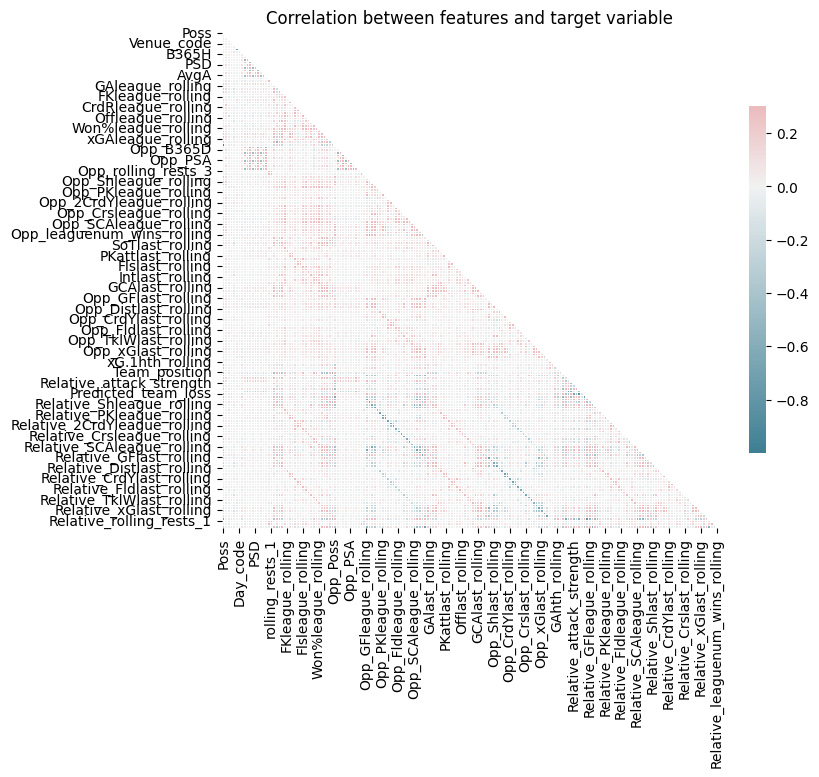

In [78]:
train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
data = train.drop(columns=['Date'])

# compute the correlation matrix
corr_mat = data.corr()

# mask out upper triangle (correlation matrices are symmetric)
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(8, 9))
# generate custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)   
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation between features and target variable')
plt.show()

## Creating models and training

In [79]:
predictors = ['Team_code', 'Opp_code', 'Venue_code', 'Hour', 'Day_code']
additional_predictors = ['rolling_rests_1', 'rolling_rests_3',
                           'leaguenum_wins_rolling']
# predictors = predictors + league_ravg_new_cols + last_ravg_new_cols + hth_ravg_new_cols + additional_predictors
# predictors = predictors + ['Opp_' + column for column in league_ravg_new_cols]
# predictors = predictors + ['Opp_' + column for column in last_ravg_new_cols]
# predictors = predictors + ['Opp_' + column for column in additional_predictors]
predictors = predictors + ['Relative_pos', 'hthnum_wins_rolling',
                           'Relative_rolling_rests_1', 'Relative_rolling_rests_3',
                           'Relative_leaguenum_wins_rolling', 'Relative_attack_strength',
                           'Relative_defense_strength', 'Predicted_team_win', 'Predicted_team_draw', 
                            'Predicted_team_loss', 'Relative_ratings']
predictors = predictors + relative_cols

train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
val = train[train['Date'] >= '2024-03-14']
train = train[train['Date'] < '2024-03-14']
test = past_matches[past_matches['Season'] > SEASON_SPLIT]
train_X = train[predictors]
val_X = val[predictors]
test_X = test[predictors]
train_Y = train['Target']
val_Y = val['Target']
test_Y = test['Target']

In [80]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
clf.fit(train_X, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(9), 'min_samples_split': np.int64(9), 'n_estimators': np.int64(180)}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        99
         1.0       0.53      0.68      0.60       168
         2.0       0.48      0.66      0.56       143

    accuracy                           0.51       410
   macro avg       0.34      0.45      0.38       410
weighted avg       0.39      0.51      0.44       410



In [81]:
feature_importance = pd.Series(refined_rf_model.feature_importances_, index=train_X.columns).sort_values(ascending=False)
feature_importance

Relative_pos                    0.051794
Relative_ratings                0.042142
Relative_xGleague_rolling       0.029612
Relative_SCAleague_rolling      0.028749
Predicted_team_loss             0.028440
                                  ...   
Relative_PKlast_rolling         0.003097
Relative_PKattlast_rolling      0.002990
Relative_2CrdYleague_rolling    0.002792
Relative_CrdRlast_rolling       0.002388
Relative_2CrdYlast_rolling      0.001852
Length: 61, dtype: float64

In [93]:
THRESHOLD = 0.015
selected_features = feature_importance[feature_importance >= THRESHOLD].index
print(len(selected_features))
train_X_selected = train_X[selected_features]
test_X_selected = test_X[selected_features]

35


In [83]:
result = permutation_importance(refined_rf_model, val_X, val_Y, n_repeats=10, random_state=42)

# Convert to DataFrame
importances_df = pd.DataFrame({
    "feature": val_X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

non_zero_importances = importances_df[importances_df['importance_mean'] > 0]

print(non_zero_importances)

                        feature  importance_mean  importance_std
5                  Relative_pos         0.028713        0.013612
15             Relative_ratings         0.017822        0.021601
14          Predicted_team_loss         0.006931        0.008911
20  Relative_Distleague_rolling         0.003960        0.004850
2                    Venue_code         0.002970        0.013320
34   Relative_SCAleague_rolling         0.001980        0.007409
55    Relative_Won%last_rolling         0.001980        0.003960
36    Relative_xGleague_rolling         0.001980        0.003960
25  Relative_CrdRleague_rolling         0.000990        0.002970
58      Relative_xGlast_rolling         0.000990        0.002970


In [94]:
features = non_zero_importances['feature']
train_X_selected2 = train_X[features]
test_X_selected2 = test_X[features]

In [85]:
common_features = [feature for feature in features if feature in selected_features]
common_features

['Relative_pos',
 'Relative_ratings',
 'Predicted_team_loss',
 'Relative_Distleague_rolling',
 'Venue_code',
 'Relative_SCAleague_rolling',
 'Relative_Won%last_rolling',
 'Relative_xGleague_rolling',
 'Relative_xGlast_rolling']

In [130]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_selected)
test_X_scaled = scaler.transform(test_X_selected)
train_X_scaled2 = scaler.fit_transform(train_X_selected2)
test_X_scaled2 = scaler.transform(test_X_selected2)

In [102]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
clf.fit(train_X_scaled, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X_scaled)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(4), 'min_samples_split': np.int64(7), 'n_estimators': np.int64(175)}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        99
         1.0       0.54      0.70      0.61       168
         2.0       0.49      0.66      0.56       143

    accuracy                           0.52       410
   macro avg       0.34      0.45      0.39       410
weighted avg       0.39      0.52      0.45       410



In [96]:
xgboost_model = XGBClassifier(random_state=42)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X_scaled, train_Y)
refined_xgboost_model = xgboost_clf.best_estimator_
xgboost_preds = refined_xgboost_model.predict(test_X_scaled)
print(xgboost_clf.best_params_)
print(classification_report(test_Y, xgboost_preds, zero_division=0))

{'alpha': np.int64(5), 'eta': np.float64(0.1), 'max_depth': np.int64(1)}
              precision    recall  f1-score   support

         0.0       0.50      0.01      0.02        99
         1.0       0.53      0.73      0.62       168
         2.0       0.51      0.63      0.56       143

    accuracy                           0.52       410
   macro avg       0.51      0.46      0.40       410
weighted avg       0.52      0.52      0.45       410



In [135]:
svc_model = SVC(random_state=42, probability=True)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X_scaled, train_Y)
refined_svc_model = svc_clf.best_estimator_
svc_preds = refined_svc_model.predict(test_X_scaled)
print(svc_clf.best_params_)
print(classification_report(test_Y, svc_preds, zero_division=0))

{'C': np.float64(0.30000000000000004), 'kernel': 'sigmoid'}
              precision    recall  f1-score   support

         0.0       0.50      0.01      0.02        99
         1.0       0.53      0.72      0.61       168
         2.0       0.50      0.63      0.56       143

    accuracy                           0.52       410
   macro avg       0.51      0.45      0.40       410
weighted avg       0.51      0.52      0.45       410



In [100]:
lr_model = LogisticRegression(random_state=42, max_iter=5000000)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X_scaled, train_Y)
refined_lr_model = lr_clf.best_estimator_
lr_preds = refined_lr_model.predict(test_X_scaled)
print(lr_clf.best_params_)
print(classification_report(test_Y, lr_preds, zero_division=0))

{'C': np.float64(0.1), 'solver': 'saga'}
              precision    recall  f1-score   support

         0.0       0.12      0.02      0.03        99
         1.0       0.53      0.65      0.59       168
         2.0       0.48      0.63      0.55       143

    accuracy                           0.49       410
   macro avg       0.38      0.43      0.39       410
weighted avg       0.42      0.49      0.44       410



In [167]:
normalized_sample_weights = compute_sample_weight(class_weight={0:2, 1:1, 2:1}, y=train_Y)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_xgboost_model = xgboost_clf.best_estimator_
better_xgboost_preds = better_xgboost_model.predict(test_X_scaled2)
print(xgboost_clf.best_params_)
print(classification_report(test_Y, better_xgboost_preds, zero_division=0))

{'alpha': np.int64(5), 'eta': np.float64(0.1), 'max_depth': np.int64(7)}
              precision    recall  f1-score   support

         0.0       0.17      0.14      0.16        99
         1.0       0.52      0.60      0.55       168
         2.0       0.49      0.46      0.48       143

    accuracy                           0.44       410
   macro avg       0.39      0.40      0.40       410
weighted avg       0.43      0.44      0.43       410



In [168]:
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_svc_model = svc_clf.best_estimator_
better_svc_preds = better_svc_model.predict(test_X_scaled2)
print(svc_clf.best_params_)
print(classification_report(test_Y, better_svc_preds, zero_division=0))

{'C': np.float64(0.30000000000000004), 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.26      0.32      0.29        99
         1.0       0.56      0.57      0.57       168
         2.0       0.58      0.48      0.52       143

    accuracy                           0.48       410
   macro avg       0.47      0.46      0.46       410
weighted avg       0.49      0.48      0.48       410



In [169]:
lr_model = LogisticRegression(random_state=42, max_iter=100000000)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X_scaled2, train_Y, sample_weight=normalized_sample_weights)
better_lr_model = lr_clf.best_estimator_
better_lr_preds = better_lr_model.predict(test_X_scaled2)
print(lr_clf.best_params_)
print(classification_report(test_Y, better_lr_preds, zero_division=0))

{'C': np.float64(0.5), 'solver': 'saga'}
              precision    recall  f1-score   support

         0.0       0.29      0.30      0.30        99
         1.0       0.57      0.60      0.58       168
         2.0       0.56      0.51      0.53       143

    accuracy                           0.50       410
   macro avg       0.47      0.47      0.47       410
weighted avg       0.50      0.50      0.50       410



In [170]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_rf_model = clf.best_estimator_
better_rf_preds = better_rf_model.predict(test_X_scaled2)
print(clf.best_params_)
print(classification_report(test_Y, better_rf_preds, zero_division=0))

{'max_depth': np.int64(4), 'min_samples_split': np.int64(2), 'n_estimators': np.int64(110)}
              precision    recall  f1-score   support

         0.0       0.23      0.13      0.17        99
         1.0       0.54      0.66      0.59       168
         2.0       0.54      0.56      0.55       143

    accuracy                           0.50       410
   macro avg       0.44      0.45      0.44       410
weighted avg       0.47      0.50      0.48       410



In [171]:
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_estimators=110, min_samples_split=2, max_depth=4)),
    ('xgb', XGBClassifier(alpha=5, random_state=42, eta=0.1, max_depth=7)),
    ('svc', SVC(random_state=42, C=0.6, kernel='sigmoid', probability=True)),
    ('lr', LogisticRegression(random_state=42, C=0.5, solver='saga', max_iter=10000000))
]

voter = VotingClassifier(estimators=base_estimators, voting='soft')

param_grid = {
    'weights': [(w1, w2, w3, w4) for w1 in range(1,5) for w2 in range(1,5) for w3 in range(1,5) for w4 in range(1,5)]
}

voting_clf = GridSearchCV(estimator=voter, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
voting_clf.fit(train_X_scaled2, train_Y, sample_weight=normalized_sample_weights)
refined_voting_model = voting_clf.best_estimator_
voter_preds = refined_voting_model.predict(test_X_scaled2)
voter_proba = refined_voting_model.predict_proba(test_X_scaled2)

print(voting_clf.best_params_)
print(classification_report(test_Y, voter_preds, zero_division=0))

{'weights': (3, 2, 1, 1)}
              precision    recall  f1-score   support

         0.0       0.19      0.08      0.11        99
         1.0       0.55      0.70      0.62       168
         2.0       0.55      0.59      0.57       143

    accuracy                           0.51       410
   macro avg       0.43      0.46      0.43       410
weighted avg       0.46      0.51      0.48       410



In [172]:
from sklearn.metrics import log_loss

voter_proba = np.clip(voter_proba, 0, 1)
voter_proba = voter_proba / voter_proba.sum(axis=1, keepdims=True) 
logloss = log_loss(test_Y, voter_proba)
print("Log Loss:", logloss)

Log Loss: 1.037442062899356


In [173]:
def multiclass_brier_score(y_true, y_proba):
    y_true = y_true.astype(int)
    n_samples, n_classes = y_proba.shape
    # one-hot encode y_true
    y_true_oh = np.zeros_like(y_proba)
    y_true_oh[np.arange(n_samples), y_true] = 1
    # mean squared error
    return np.mean(np.sum((y_proba - y_true_oh) ** 2, axis=1))

brier = multiclass_brier_score(test_Y, voter_proba)
print("Brier Score:", brier)

Brier Score: 0.6216609033190452


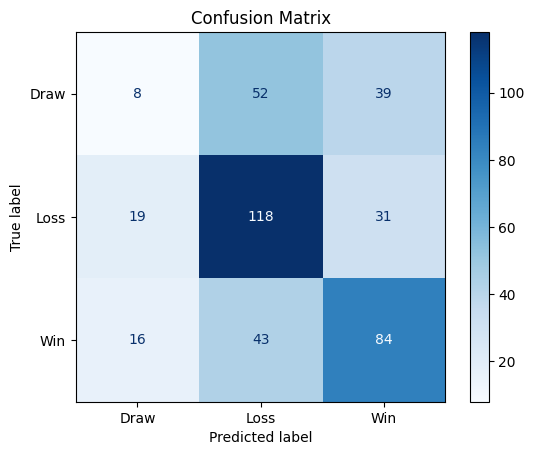

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true = actual labels (0=loss, 1=draw, 2=win for example)
# y_pred = model predictions

cm = confusion_matrix(test_Y, voter_preds, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Draw", "Loss", "Win"])
disp.plot(cmap="Blues", values_format="d")  # "d" for raw counts, ".2f" for proportions
plt.title("Confusion Matrix")
plt.show()


## Predicting upcoming matches

In [176]:
full_train_X = pd.concat([train_X_selected2, test_X_selected2])
full_train_Y = pd.concat([train_Y, test_Y])
normalized_sample_weights2 = compute_sample_weight(class_weight={0:2, 1:1, 2:1}, y=full_train_Y)

full_train_X_scaled = scaler.fit_transform(full_train_X)
predict_X = future_matches[features]
predict_X_scaled = scaler.transform(predict_X)

refined_voting_model.fit(full_train_X_scaled, full_train_Y, sample_weight=normalized_sample_weights2)
voter_preds = refined_voting_model.predict(predict_X_scaled)
voter_proba = refined_voting_model.predict_proba(predict_X_scaled)
result_mapping_dict = {'0': 'Draw', '1': 'Loss', '2': 'Win'}
voter_preds = [result_mapping_dict.get(str(int(result))) for result in voter_preds]
team_mapping_dict2 = {value: key for key, value in team_mapping_dict.items()}
team_names = future_matches['Team_code'].map(team_mapping_dict2)
opp_names = future_matches['Opp_code'].map(team_mapping_dict2)
result = pd.DataFrame({'Date': future_matches['Date'],
                       'Team_position': future_matches['Team_position'],
                       'Team':team_names, 
                        'Pred':voter_preds, 'Opponent': opp_names,
                        'Opp_position': future_matches['Opp_position'],
                        'Team_win%': voter_proba[:,2],
                        'Opp_win%': voter_proba[:,1],
                        'Draw%': voter_proba[:,0]})
for col in ['Team_win%', 'Opp_win%', 'Draw%']:
    result[col] = (result[col] * 100).round(2)
result

,Date,Team_position,Team,Pred,Opponent,Opp_position,Team_win%,Opp_win%,Draw%
2360,2025-09-20,18.0,West Ham,Loss,Crystal Palace,9.0,29.53,37.15,33.32
2361,2025-09-20,1.0,Liverpool,Win,Everton,6.0,53.95,16.00,30.06
2362,2025-09-20,13.0,Brighton,Win,Tottenham,3.0,37.54,34.07,28.39
2363,2025-09-20,12.0,Brentford,Loss,Fulham,11.0,28.58,49.18,22.24
2364,2025-09-20,16.0,Leeds United,Win,Wolves,20.0,43.46,29.14,27.40
2365,2025-09-20,14.0,Manchester Utd,Loss,Chelsea,5.0,23.02,38.96,38.01
2369,2025-09-20,15.0,Nott'ham Forest,Win,Burnley,17.0,36.93,31.24,31.83
2374,2025-09-21,2.0,Arsenal,Win,Manchester City,8.0,46.72,19.18,34.09
2375,2025-09-21,10.0,Newcastle Utd,Loss,Bournemouth,4.0,28.87,40.03,31.09
2376,2025-09-21,7.0,Sunderland,Loss,Aston Villa,19.0,31.05,35.60,33.35
